# Principal Component Analysis

So far, we have worked with relatively small datasets, with a limited set of interpretable variables. We have seen how models such as linear and logistic regression can help in understanding and interpret the relationships between variables.

In practice, in many cases, we will work with larger sets of data, where individual variables are not always interpretable. **Consider for instance a dataset of medical images with a resolution of $600 \times 600$ pixels. We may want to be able to apply data analysis to such images, for instance, for automated diagnosis, but, if we think about it, we obtain a set of $360000$ individual columns. Moreover, such columns are not directly interpretable (each one represent the gray value of a specific pixel in the image).**

In most of these cases, **the data will be highly redundant, with different variables being dependent or reporting similar data in different form**. Think about it: if there is a large number of variables, it is more probable that some of them capture the same phenomenon from different points of view.

## Data as N-Dimensional Points and Features
Before going further, we need to clarify some terminology. When many variables are available, we usually refer to the observations as **n-dimensional data points**. Consider the following data:

|Subject|Height (cm)|Weight (Kg)|
|-|-|-|
|1|175|70|
|2|160|60|
|3|180|78|
|4|160|75|
|5|155|58|
|6|190|110|

We can see each of these observations (the rows of the matrix) as a data point. Further, we can geometrically represent such points as follows:

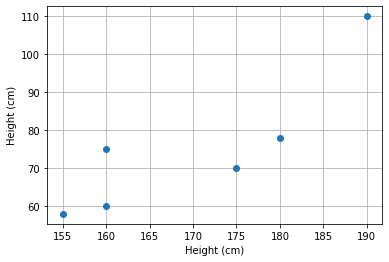

In [316]:
from matplotlib import pyplot as plt
plt.plot([175,160,180,160,155,190], [70,60,78,75,58,110],'o')
plt.grid()
plt.xlabel('Height (cm)')
plt.ylabel('Height (cm)')
plt.show()

Each observation is a 2D point in the Cartesian space. This geometrical interpretation of data is central to data analysis and very convenient **when many different variables are available**. 

Each of the variables, we also be referred to as **a feature of the data**. This is also very convenient when multiple variables are available and in particular when they are not directly interpretable. For instance, a dataset of images of $100x100 pixels$ can be seen as a collection of $10000$-dimensional vectors, where each vector's dimension is a "feature", i.e., the value of a specific pixel of the image.

Throughout this lecture and from now on, we will ofter refer to data as **collections of n-dimensional points or observations of n different features**.


## Feature Selection vs Feature Reduction
We have seen how, when many variables are available, it makes sense to select a subset of such variables. In regression analysis, in particular, we have seen how, when features are highly correlated, we should **discard some of them to reduce collinearity**. Indeed, if two variables $x$ and $y$ are highly correlated, one of the two is redundant to a given extent, and we can ignore it.

We have seen how variables can be selected in different ways:
* By looking at the correlation matrix, we can directly find those pairs of variables which are highly correlated;
* When defining a linear or logistic regressor, we can remove those variables with a high p-value. We have seen that these are variables which do not contribute significantly to the prediction of the dependent variable, given all other variables present in the regressor;
* Techniques such as **Ridge and Lasso regression** allow to perform some form of variable (or feature) selection, setting very low or zero coefficients for variables which do not contribute significantly to regression.

**In general, however, when we discard a set of variable, we throw away some informative content, unless the variables we are removing can be perfectly reconstructed from the variables we are keeping, e.g., because they are linear combinations of other variables.**

Instead of selecting a subset of features to work with, **feature reduction techniques** aim to **find a new set of features which summarize the original set of features losing a small amount of information, while maintaining a limited number of dimensions**.

## Feature Reduction Example
Let us consider the Iris dataset. In particular, we will consider two features: `sepal length` and `petal length`:

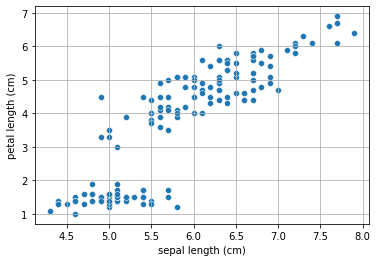

In [317]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt

data = load_iris(as_frame=True)['data']
sns.scatterplot(x='sepal length (cm)', y='petal length (cm)', data=data)
plt.grid()
plt.show()

We can see from the plot above that the two features are highly correlated. Let us compute the Pearson coefficient and the related p-value:

In [318]:
from scipy.stats import pearsonr
pearsonr(data['petal length (cm)'], data['sepal length (cm)'])

PearsonRResult(statistic=0.8717537758865831, pvalue=1.0386674194498827e-47)

Both features represent the length of two physical characteristics of the flowers, hence **it is no wonder that they are correlated!**. It would be useful to find a transformation of the data $(x_1,x_2)$ into a new set of features $(z_1,z_2)$ such that:

* Both $z_1$ and $z_2$ are computed from $x_1$ and $x_2$, and hence each individual new variable can "summarize" the informative content of both variables;
* $z_1$ and $z_2$ are sorted by the amount of informative content that they carry about the original variables $(x_1,x_2)$. If this condition is satisfied, then we can select $z_1$ and discard $z_2$ to reduce the dimensionality of the original data (from $2$ to $1$ variable) while retaining the largest amount of information.

We also note that, ideally, we expect the **new variables $z_1$ and $z_2$ to be decorrelated**. Indeed, if $z_1$ and $z_2$ are decorrelated, adding $z_2$ to the picture only brings additional informative content about the original data, avoiding "repeating" information which is already summarized in $z_1$.

### Rotating Around the Origin
In our example, we note that a specific rotation of the data around the central point

$$(\overline x, \overline y) = \big(\frac{1}{N}\sum_{i=1}^N x_1^{(i)}, \frac{1}{N}\sum_{i=1}^N x_2^{(i)}\big)$$

brings the characteristics highlighted above:

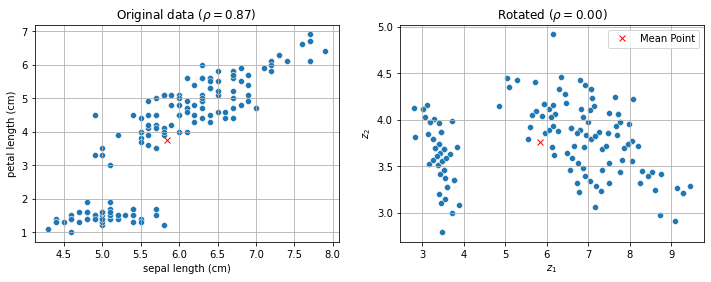

In [319]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

_,axes = plt.subplots(1,2,figsize=(12,4))

corr = data[["sepal length (cm)","petal length (cm)"]].corr().values[0,1]

pca = PCA(n_components=2)
pca.fit(data[["sepal length (cm)","petal length (cm)"]])
angle = -np.arccos(pca.components_[0,0])

transformed = pca.transform(data[["sepal length (cm)","petal length (cm)"]])
mean = data[["sepal length (cm)","petal length (cm)"]].mean().values.reshape(1,-1)
transformed += mean
transformed = pd.DataFrame({
    'sepal length (cm)' : transformed[:,0],
    'petal length (cm)' : transformed[:,1]
})

corr2 = transformed[["sepal length (cm)","petal length (cm)"]].corr().values[0,1]

sns.scatterplot(x='sepal length (cm)', y='petal length (cm)', data=data, ax=axes[0])
axes[0].plot(mean[0,0], mean[0,1],'rx')
axes[0].grid()

axes[0].set_title(f'Original data ($\\rho={corr:0.2f}$)')

sns.scatterplot(x='sepal length (cm)', y='petal length (cm)', data=transformed, ax=axes[1])
axes[1].plot(mean[0,0], mean[0,1],'rx', label='Mean Point')
axes[1].grid()
axes[1].set_xlabel("$z_1$")
axes[1].set_ylabel("$z_2$")

axes[1].set_title(f'Rotated ($\\rho={corr2:0.2f}$)')
plt.legend()
plt.show()

As we can see, this specific rotation (we will see later how to compute the optimal one) has produced a version of the data which is uncorrelated. Note that the rotation around the mean point is a rigid and invertible transformation, hence there is no loss of information.

### Amount of Information, Reconstruction Error and Variance
Without loss of generality, let us now consider the two variables:

$$h_1 = x_1 - \overline x_1, h_2 = x_2 - \overline x_2 $$

These have been obtained by shifting the data to the mean point. Note that this shift has not changed in any way the informative content of the variables.

Since the data has been rotated, we can see the computation of $z_1$ and $z_2$ as follows:

$$z_1 = h_1 \cos(\theta)  - h_2 \sin(\theta)$$
$$z_2 = h_1 \sin(\theta) + h_2 \cos(\theta)$$

Where $\theta$ is the optimal angle. We will see how to compute the optimal rotation later. For now let us assume that $\theta=-1.17 rad$ (this is indeed the rotation that has been applied to make the considered set of data uncorrelated).

We can invert the transformation as follows:


$$h_1 = z_1 \cos(-\theta)  - z_2 \sin(-\theta)$$
$$h_2 = z_1 \sin(-\theta) + z_2 \cos(-\theta)$$

If we want to reduce the number of variables, we could either discard $z_1$ or $z_2$. If we discard $z_2$, hence setting it to zero, we can reconstruct the $x$ and $y$ values as follows:

$$\hat h_1' = z_1 \cos(-\theta)$$
$$\hat h_2' = z_1 \sin(-\theta)$$

If we discard $z_1$, we obtain:

$$\hat h_1'' = - z_2 \sin(-\theta)$$
$$\hat h_2'' = z_2 \cos(-\theta)$$

To have an idea of how much information we lose by discarding one fo the two variables, we can compute the reconstruction error, i.e., the MSE between the predicted and original values. We have:

$$MSE' = \frac{1}{N}\sum_{i=1}^N (\hat h_1' - h_1)^2 + (\hat h_2' - h_2)^2, MSE'' = \frac{1}{N} \sum_{i=1}^N (\hat h_1'' - h_1)^2 + (\hat h_2'' - h_2)^2$$

Another strategy, would be to avoid the transformation altogether and set either $x=0$ and $y=0$. We can hence consider other two MSE errors:

$$MSE_1 = \frac{1}{N}\sum_{i=1}^N (h_1 - h_1)^2 + (0 - h_2)^2, MSE_2 = \frac{1}{N} \sum_{i=1}^N (0 - h_1)^2 + (h_2 - h_2)^2$$

In practice, these MSE values will be as follows:

In [364]:
h1 = data['sepal length (cm)'] - data['sepal length (cm)'].mean()
h2 = data['petal length (cm)'] - data['petal length (cm)'].mean()

z1 = h1 * np.cos(angle) - h2 * np.sin(angle)
z2 = h1 * np.sin(angle) + h2 * np.cos(angle)

hat_h1 = z1*np.cos(-angle)
hat_h2 = z1*np.sin(-angle)

hat_h1_1 = -z2*np.sin(-angle)
hat_h2_1 = z2*np.cos(-angle)

MSE = ((hat_h1-h1)**2 + (hat_h2-h2)**2).mean()
MSE1 = ((hat_h1_1-h1)**2 + (hat_h2_1-h2)**2).mean()

MSE_h1 = ((0-h2)**2).mean()
MSE_h2 = ((0-h1)**2).mean()

#MSE, MSE1
print(pd.DataFrame({'MSE\'':[MSE], 'MSE\'\'': [MSE1], 'MSEx':[MSE_h1], 'MSEy':[MSE_h2]}).to_string(index=False))

    MSE'    MSE''     MSEx     MSEy
0.139139 3.637486 3.095503 0.681122


As can be seen, reconstructing the data using only $z_1$ has the least MSE score, suggesting a higher informative content about the original data.

Note that the MSE can also be seen as the sum of the squares of the dashed lines in the following plots:

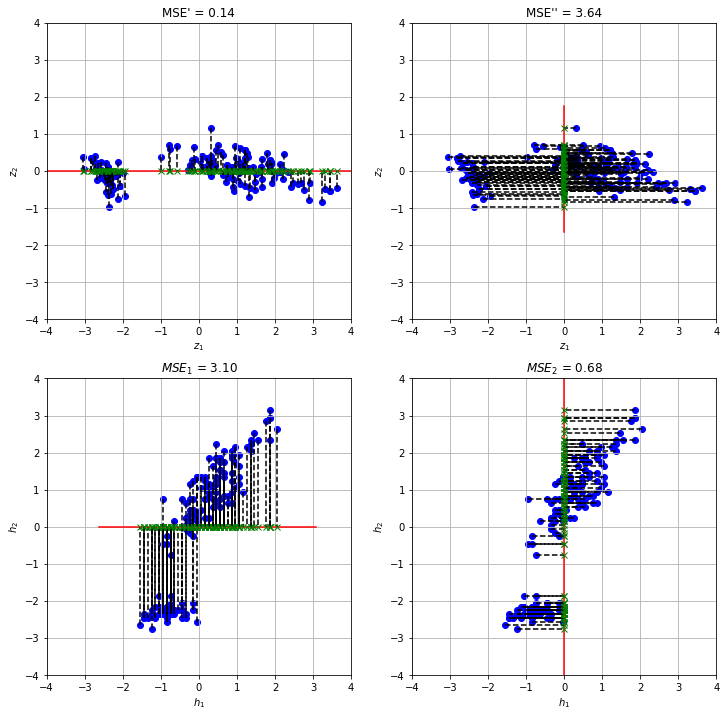

In [365]:
import numpy as np
import matplotlib.pyplot as plt

def plot_projection(points, vector, ax, lab, labs):
    xlab, ylab = labs
    vector = vector.astype('float64')/np.linalg.norm(vector)

    xmin = points[:,0].min()*1.7
    ymin = points[:,1].min()*1.7
    xmax = points[:,0].max()*1.5
    ymax = points[:,1].max()*1.5


    # Plot the points
    ax.scatter(points[:,0], points[:,1], color='b')

    maxpoint = np.array([xmax,ymax])
    proj = np.dot(maxpoint,vector)/ np.linalg.norm(vector) ** 2 * vector

    ax.plot([vector[0]*xmin, vector[0]*xmax], [vector[1]*ymin, vector[1]*ymax],'-r')

    for i in range(len(points)):
        projection = np.dot(points[i], vector) / np.linalg.norm(vector) ** 2 * vector
        # # Draw a line connecting the point to its projection
        ax.plot([points[i][0], projection[0]], [points[i][1], projection[1]], linestyle='--', color='k')
    
        ax.plot(projection[0],projection[1], color='g', marker='x')

    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    #ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(lab)

dat = np.vstack([h1,h2]).T
dat2 = np.vstack([z1,z2]).T

axs = plt.subplots(2,2, figsize=(12,12))[1].ravel()
plot_projection(dat2, np.array([1, 0]), axs[0], f'MSE\' = {MSE:0.2f}',['$z_1$',"$z_2$"])
plot_projection(dat2, np.array([0, 1]), axs[1], f'MSE\'\' = {MSE1:0.2f}',['$z_1$',"$z_2$"])

plot_projection(dat, np.array([1, 0]), axs[2], f'$MSE_1$ = {MSE_h1:0.2f}',['$h_1$',"$h_2$"])
plot_projection(dat, np.array([0, 1]), axs[3], f'$MSE_2$ = {MSE_h2:0.2f}',['$h_1$',"$h_2$"])
plt.show()


As can be seen, reconstructing the data with the $z_1$ variable, corresponds to projecting it to the $z_1$ axis, after the data has been appropriately rotated. This has the lowest error, indicating that $z_1$ is the most informative single direction.

We can also see that **the $z_1$ variable is the one with the largest variance**:

In [326]:
print(f"Variance of z1: {np.var(z1):0.2f}")
print(f"Variance of z2: {np.var(z2):0.2f}")
print(f"Variance of h1: {np.var(h1):0.2f}")
print(f"Variance of h2: {np.var(h2):0.2f}")

Variance of z1: 3.64
Variance of z2: 0.14
Variance of h1: 0.68
Variance of h2: 3.10


Intuitively, **larger variance lends to a larger informative content, and hence to a smaller reconstruction error**. Indeed, in variables exhibiting low variance, points tend to be less distinguishable, hence making it harder to reconstruct the original data.

### Projection Along a Direction

Note that we can see the transformation:

$$z_1 = h_1 \cos(\theta)  - h_2 \sin(\theta)$$

As follows:

$$z_1 = h_1 w_1  - h_2 w_2$$

If we set $\mathbf{w} = (w_1,w_2)$, $\mathbf{h}=(h_1,h_2)$, and $\mathbf{z} = (z_1,z_2)$, we can write:

$$\mathbf{z} = \mathbf{w}^T \mathbf{h}$$

We also note that $||\mathbf{w}|| = \sqrt{w_1^2 + w_2^2} = \sqrt{\sin^2\theta + \cos^2 \theta}= 1$.

We recall that **the product $\mathbf{w}^T\mathbf{x}$ corresponds to projecting the point $\mathbf{x}$ to the unit vector $\mathbf{w}$ indicating the axis of a new coordinate system**.

Indeed:

$$ \cos \theta = \frac{\mathbf{w}^T\mathbf{x}}{||\mathbf{w}|| \cdot ||\mathbf{x}||}$$

where $\theta$ is the angle between the $\mathbf{w}$ unit vector and the $\mathbf{x}$ vector. Since $||\mathbf{w}|| = 1$, we obtain:

$$ ||\mathbf{x}|| \cos \theta = \mathbf{w}^T\mathbf{x}$$

This is graphically shown as follows:

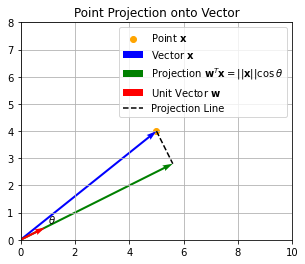

In [327]:
import numpy as np
import matplotlib.pyplot as plt

def plot_projection(point, vector):
    projection = np.dot(point, vector) / np.linalg.norm(vector) ** 2 * vector

    fig, ax = plt.subplots()


    # Plot the point
    ax.scatter(point[0], point[1], color='orange', label='Point $\mathbf{x}$')

    ax.quiver(0, 0, point[0], point[1], angles='xy', scale_units='xy', scale=1, color='b', label='Vector $\mathbf{x}$')

    # Plot the projection
    ax.quiver(0, 0, projection[0], projection[1], angles='xy', scale_units='xy', scale=1, color='g', linestyle='dashed', label='Projection $\mathbf{w}^T\mathbf{x} = ||\mathbf{x}|| \cos \\theta$')

    # Plot the vector
    ax.quiver(0, 0, vector[0], vector[1], angles='xy', scale_units='xy', scale=1, color='r', label='Unit Vector $\mathbf{w}$')


    # Draw a line connecting the point to its projection
    ax.plot([point[0], projection[0]], [point[1], projection[1]], linestyle='--', color='k', label='Projection Line')

    ax.text(1,0.6,"$\\theta$")
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.legend(loc='upper right')

    plt.title("Point Projection onto Vector")
    plt.show()

# Example usage
point = np.array([5, 4])
vector = np.array([2, 1]).astype('float64')
vector/=np.linalg.norm(vector)

plot_projection(point, vector)


**A given choice of a rotation angle $\theta$ or a vector $\mathbf{w}$ will hence identify a new direction along which to project all points to obtain the feature $z_1$**, as shown in the following plot:

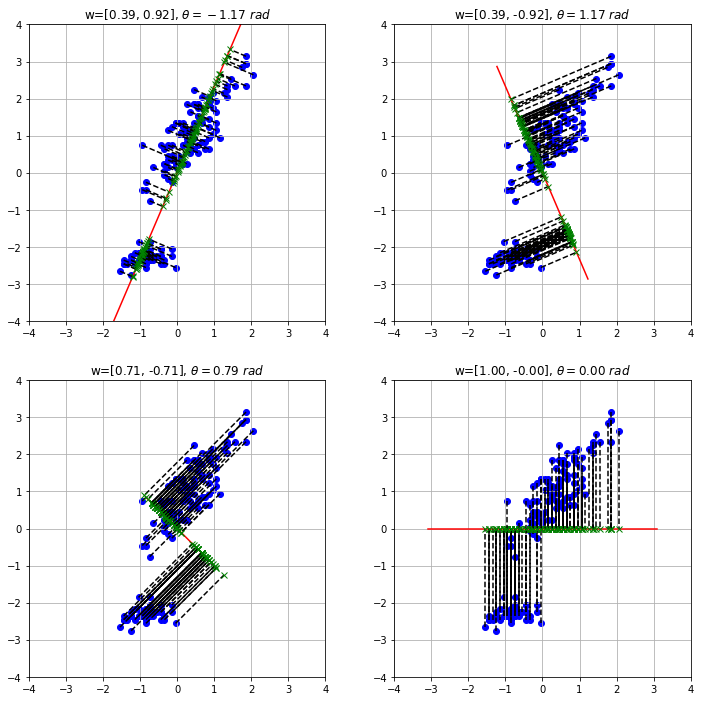

In [363]:
import numpy as np
import matplotlib.pyplot as plt

def plot_projection(points, vector, ax, angle):
    vector = vector.astype('float64')/np.linalg.norm(vector)

    xmax = points[:,0].max()*1.5
    xmin = points[:,0].min()*1.5
    ymax = points[:,1].max()*1.5
    ymin = points[:,1].min()*1.5


    # Plot the points
    ax.scatter(points[:,0], points[:,1], color='b')

    maxpoint = np.array([xmax,ymax])
    proj = np.dot(maxpoint,vector)/ np.linalg.norm(vector) ** 2 * vector

    ax.plot([0,proj[0]], [0, proj[1]],'-r')
    ax.plot([0,-proj[0]], [0, -proj[1]],'-r')

    for i in range(len(points)):
        projection = np.dot(points[i], vector) / np.linalg.norm(vector) ** 2 * vector
        # # Draw a line connecting the point to its projection
        ax.plot([points[i][0], projection[0]], [points[i][1], projection[1]], linestyle='--', color='k')
    
        ax.plot(projection[0],projection[1], color='g', marker='x')

    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.set_title(f"w=[{vector[0]:0.2f}, {vector[1]:0.2f}], $\\theta={angle:.2f}\ rad$")


dat = np.vstack([h1,h2]).T

axs = plt.subplots(2,2, figsize=(12,12))[1].ravel()
plot_projection(dat, np.array([np.cos(angle), -np.sin(angle)]), axs[0], angle)
plot_projection(dat, np.array([np.cos(-angle), -np.sin(-angle)]), axs[1], - angle)
plot_projection(dat, np.array([np.cos(np.pi/4), -np.sin(np.pi/4)]), axs[2], np.pi/4)
plot_projection(dat, np.array([np.cos(0), -np.sin(0)]), axs[3], 0)
plt.show()


The plots above show how multiplying all points by a vector $\mathbf{w}$ is **equivalent to rotating the data by a given angle, and then projecting the data to the new $x$ axis**. We also note that good projections are the ones that:

* Maximize the variance along the $z_1$ axis;
* Minimize the MSE, i.e., the length of the dashed black lines.

### An Index to Rule them All

We can see the variable $z_1$ found by rotating the data as **a single index summarizing the original data**. Since it is the single dimension which leads to the smallest reconstruction error, **if we have a computational budget of a single variable**, it does make sense to represent the data using this value.

Recall that, in the end, $z_1$ is a linear combination of $h_1$ and $h_2$:

$$z_1 = h_1 w_1 + h_2 w_2$$

We can see $w_1$ and $w_2$ as two weights denoting the relative importance of the original variables. If $h_1$ and $h_2$ are `sepal length` and `petal length` as in our example, $z_1$ can be seen as a new "**largeness**" feature and, in this simple example, we may even see it as a way to sort our observations from smaller to larger.

## General Formulation
We have seen a simple example in the case of two variables. Let us now discuss the general formulation in the case of $D$-dimensional variables.

Let $\{\mathbf{x}_n\}$ be a set of $N$ observations, where $n=1,\ldots,N$, and $\mathbf{x}_n$ is a vector of dimensionality $D$. We will define Principal Component Analysis as a projection of the data to $M \lt D$ dimensions such that the variance of the projected data is maximized.

We will first consider the case in which $M=1$. In this case, we want to find a D-dimensional vector $\mathbf{u}_1$ such that, projecting the data to this vector, variance is maximized. Without loss of generality, we will choose $\mathbf{u}_1$ such that $\mathbf{u}_1^T\mathbf{u}=1$. This corresponds to choosing $\mathbf{u}_1$ as a **unit vector**, which makes sense, as we are interested in the direction of the projection. We will find this assumption useful later.

Let $\overline{\mathbf{x}}$ be the sample mean:

$$\overline{\mathbf{x}} = \sum_{n=1}^N x_n$$

The data covariance matrix $\mathbf{S}$ can be defined as follows:

$$\mathbf{S} = \frac{1}{N} \sum_{n=1}^N (\mathbf{x}_n - \overline{\mathbf{x}}) (\mathbf{x}_n - \overline{\mathbf{x}})^T$$

To see why the definition above is correct, let us consider a set of 2D points $\mathbf{x}_n=(x_n^{(1)},x_n^{(2)})$ and the mean value $\overline{\mathbf{x}} = (\overline{x}^{(1)},\overline{x}^{(2)})$. We have:

$$\mathbf{S} =  \frac{1}{N} \sum_{n=1}^N (\mathbf{x}_n - \overline{\mathbf{x}}) (\mathbf{x}_n - \overline{\mathbf{x}})^T = \frac{1}{N} \sum_{n=1}^N \left(\begin{matrix} x_n^{(1)} - \overline{x}^{(1)} \\ x_n^{(1)} - \overline{x}^{(2)} \end{matrix}\right) (x_n^{(1)} - \overline{x}^{(1)}, x_n^{(1)} - \overline{x}^{(2)})=$$

$$=\frac{1}{N} \sum_{n=1}^N \left(\begin{matrix} (x_n^{(1)}-\overline{x}^{(1)})^2 & (x_n^{(1)}-\overline{x}^{(1)})(x_n^{(2)}-\overline{x}^{(2)}) \\ (x_n^{(1)}-\overline{x}^{(1)})(x_n^{(2)}-\overline{x}^{(2)}) & (x_n^{(2)}-\overline{x}^{(2)})^2\end{matrix}\right) = $$

$$= \left(\begin{matrix} \frac{1}{N} \sum_{n=1}^N(x_n^{(1)}-\overline{x}^{(1)})^2 & \frac{1}{N} \sum_{n=1}^N(x_n^{(1)}-\overline{x}^{(1)})(x_n^{(2)}-\overline{x}^{(2)}) \\ \frac{1}{N} \sum_{n=1}^N(x_n^{(1)}-\overline{x}^{(1)})(x_n^{(2)}-\overline{x}^{(2)}) & \frac{1}{N} \sum_{n=1}^N(x_n^{(2)}-\overline{x}^{(2)})^2\end{matrix}\right)$$

We know that projecting a data point to $\mathbf{u}_1$ is done simply by the dot product:

$$ \mathbf{u}_1^T \mathbf{x} $$

The mean of the projected data is hence $\mathbf{u}_1^T \overline{\mathbf{x}}$, and its variance is:

$$\frac{1}{N} \sum_{n=1}^N (\mathbf{u}_1^T \mathbf{x}_n - \mathbf{u}_1^T \overline{\mathbf{x}}) (\mathbf{u}_1^T \mathbf{x}_n - \mathbf{u}_1^T \overline{\mathbf{x}})^T = \mathbf{u}_1^T \frac{1}{N} \sum_{n=1}^N (\mathbf{x}_n -  \overline{\mathbf{x}}) ( \mathbf{x}_n - \overline{\mathbf{x}})^T \mathbf{u}_1 = \mathbf{u}_1^T \mathbf{S}\mathbf{u}_1 $$

To find an appropriate $\mathbf{u}_1$, we need to maximize the variance of the projected data with respect to $\mathbf{u}_1$. The optimization problem can be formalized as follows:

$$\arg\max \{\mathbf{u}_1^T\mathbf{S}\mathbf{u_1}\} \text{ subject to } \mathbf{u}_1^T\mathbf{u}_1=1$$

Note that the constraint $\mathbf{u}_1^T\mathbf{u}_1=1$ is necessary. Without it, we could arbitrarily increase the variance by choosing vectors $\mathbf{u}_1$ with large modules, hence $\mathbf{u}_1^T\mathbf{u}_1 \to +\infty$.

We will not see how this optimization problem is solved in details, but it can be shown that the variance is maximized when:

$$\mathbf{u}_1^T \mathbf{S} \mathbf{u}_1 = \lambda_1$$

From the result above, we find out that:
* The solution $\mathbf{u}_1$ is an eigenvector of $\mathbf{S}$. The related eigenvalue  $\lambda_1$ is the variance along that dimension;
* Since we want to maximize the variance, among all eigenvectors, we should choose the one with the **largest eigenvalue $\lambda_1$**.

The vector $\mathbf{u}_1$ will be **the first principal component** of the data.

**We can proceed in an iterative fashion to find the other components**. In practice, it can be shown that, to obtain uncorrelated variables, it is convenient to choose the next component $\mathbf{u}_2$ such that $\mathbf{u}_2 \perp \mathbf{u}_1$. Doing so, we will form an **orthonormal base** of the data. We can hence identify the second principal component by choosing the vector $\mathbf{u}_2$ with maximizes the variance **among all vectors which are orthogonal to $\mathbf{u}_1$**.

In practice, it can be shown that the $M$ principal components can be found by choosing the $M$ eigenvectors $\mathbf{u}_1, \ldots, \mathbf{u}_M$ of the covariance matrix $\mathbf{S}$ corresponding to the largest eigenvectors $\lambda_1, \ldots, \lambda_M$.

Let us define the matrix $W$ as follows:

$$\mathbf{W} = \left(\begin{matrix}
\mathbf{u}_1 \\
\mathbf{u}_2 \\
\ldots \\
\mathbf{u}_M \\
\end{matrix}\right) = \left(\begin{matrix}
u_{11} & u_{12} & \ldots & u_{1D} \\
u_{21} & u_{22} & \ldots & u_{2D} \\
\ldots \\
u_{M1} & u_{M2} & \ldots & u_{MD} \\
\end{matrix}\right)$$

where $u_{ij}$ is the $j^{th}$ component of the vector $\mathbf{u}_i$.

Note that, given the way we constructed this matrix, it will be **a unit orthonormal matrix**. Indeed:
* All rows are perpendicular, hence the dot product of any row with any other will be $\mathbf{u}_i^T \mathbf{u}_j=1$;
* The scalar product of any row with itself will be: $\mathbf{u}_i^T \mathbf{u}_i$=1;
* As a consequence the two conditions above will be valid also for columns;
* The determinant of $\mathbf{W}$ will be 1.

If we choose $M=D$, we can hence see **$\mathbf{W}$ as a rotation matrix, coherently with our previous interpretation of the PCA**. If $M \lt D$, the matrix $\mathbf{W}$ identifies a **new basis for the data**.

Let:

$$\mathbf{X} = \left(\begin{matrix}
\mathbf{x}_1 \\
\mathbf{x}_2 \\
\ldots \\
\mathbf{x}_N \\
\end{matrix}\right) = \left(\begin{matrix}
x_{11} & x_{12} & \ldots & x_{1D} \\
x_{21} & x_{22} & \ldots & x_{2D} \\
\ldots \\
x_{N1} & x_{N2} & \ldots & x_{ND} \\
\end{matrix}\right)$$

be the $[N \times D]$ data matrix.

We can project the data matrix $X$ to the principal components with the following formula:

$$\mathbf{Z} = \mathbf{X} \mathbf{W}^T$$

$\mathbf{Z}$ will be an $[N \times M]$ matrix in which the $n^{th}$ row denotes the $n^{th}$ element of the dataset projected to the PCA space.

In geometrical terms, the PCA **performs a rotation of the D-dimensional data around the center of the data** in a way that:
* The new axes are sorted by variance;
* The projected data is uncorrelated.

## Back to Our Example
We now have the computational tools to fully understand our example. Let us plot the data again. We will consider the mean-centered data:

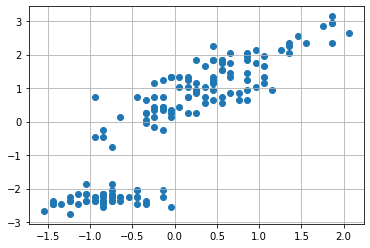

In [368]:
dat = np.vstack([h1,h2]).T
plt.scatter(x=h1, y=h2)
plt.grid()
plt.show()

We have seen that the covariance matrix plays a central role in PCA. The covariance matrix will be as follows in our case:

In [374]:
S = np.cov(dat.T)
S

array([[0.68569351, 1.27431544],
       [1.27431544, 3.11627785]])

The eigvenvalues and eigenvectors will be as follows:

In [394]:
from scipy.linalg import eig
eigenval, eigenvec = eig(S)
eigenval = np.real(eigenval)
eigenvec = eigenvec.T
print(f"Eigenvalues: {eigenval}\n")
print(f"Eigenvectors:\n {eigenvec}")

Eigenvalues: [0.1400726  3.66189877]

Eigenvectors:
 [[-0.9192793   0.39360585]
 [-0.39360585 -0.9192793 ]]


The rows of the eigenvector matrix identify two principal components. The first one is associated to a variance of about $0.14$ (the first eigvenvalue), while the second component is associated to a variance of $3.66$. Let us re-order the principal components so that eigenvalues are descending (we want the first principal component to have the largest value):

In [395]:
sort = np.argsort(eigenval)[::-1]
eigenval = eigenval[sort]
eigenvec = eigenvec[sort]

print(f"Eigenvalues: {eigenval}\n")
print(f"Eigenvectors:\n {eigenvec}")

Eigenvalues: [3.66189877 0.1400726 ]

Eigenvectors:
 [[-0.39360585 -0.9192793 ]
 [-0.9192793   0.39360585]]


The two components identify two directions along which we can project our data, as shown in the following plot:

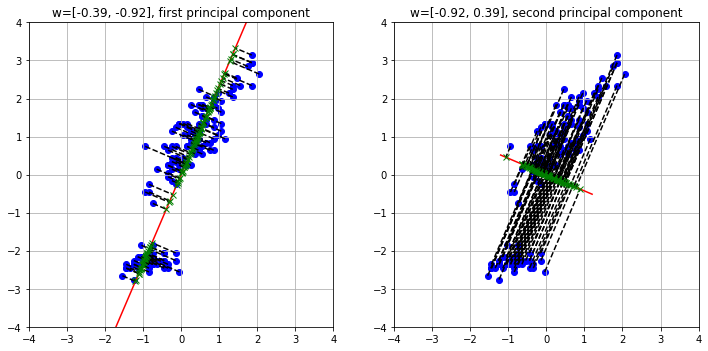

In [397]:
import numpy as np
import matplotlib.pyplot as plt

def plot_projection(points, vector, ax, angle):
    vector = vector.astype('float64')/np.linalg.norm(vector)

    xmax = points[:,0].max()*2
    xmin = points[:,0].min()*2
    ymax = points[:,1].max()*2
    ymin = points[:,1].min()*2


    # Plot the points
    ax.scatter(points[:,0], points[:,1], color='b')

    maxpoint = np.array([xmax,ymax])
    proj = np.dot(maxpoint,vector)/ np.linalg.norm(vector) ** 2 * vector

    ax.plot([0,proj[0]], [0, proj[1]],'-r')
    ax.plot([0,-proj[0]], [0, -proj[1]],'-r')

    for i in range(len(points)):
        projection = np.dot(points[i], vector) / np.linalg.norm(vector) ** 2 * vector
        # # Draw a line connecting the point to its projection
        ax.plot([points[i][0], projection[0]], [points[i][1], projection[1]], linestyle='--', color='k')
    
        ax.plot(projection[0],projection[1], color='g', marker='x')

    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.set_title(f"w=[{vector[0]:0.2f}, {vector[1]:0.2f}], {angle}")


dat = np.vstack([h1,h2]).T

axs = plt.subplots(1,2, figsize=(12,12))[1].ravel()
plot_projection(dat, eigenvec[0], axs[0], "first principal component")
plot_projection(dat, eigenvec[1], axs[1], "second principal component")
plt.show()


As we can see, the two directions are orthogonal. We can also project the data maintaining the original dimensionality with:

$$\mathbf{Z} = \mathbf{X}\mathbf{W}^T$$

The plot below compares the original and rotated data:

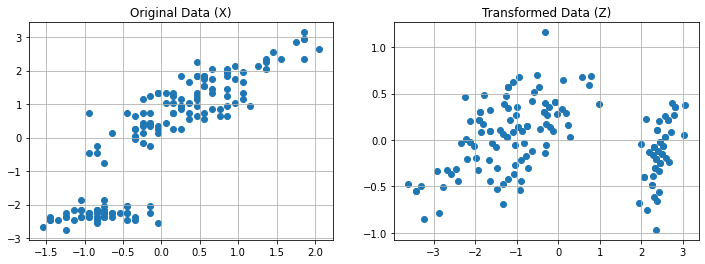

In [418]:
dat = np.vstack([h1,h2]).T
dat2 = np.matmul(dat,eigenvec.T)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(x=dat[:,0], y=dat[:,1])
plt.title("Original Data (X)")
plt.grid()
plt.subplot(122)
plt.scatter(x=dat2[:,0], y=dat2[:,1])
plt.title("Transformed Data (Z)")
plt.grid()
plt.show()

The eigenvectors can also be interpreted as vectors in the original space. Let us show them:

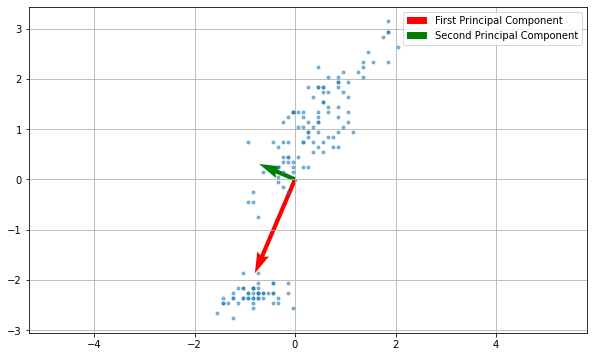

In [431]:
plt.figure(figsize=(10,6))
W = eigenvec
set2d = pd.DataFrame({'x': h1, 'y':h2})
#specifico alpha=0.5 per visualizzare i punti in trasparenza
plt.plot(set2d.x,set2d.y,'.',alpha=0.5)
#uso la funzione quiver per plottere i vettori
plt.quiver(set2d.x.mean(),set2d.y.mean(),W[0,0],W[1,0], scale=20/eigenval[0], color='red', label='First Principal Component')
plt.quiver(set2d.x.mean(),set2d.y.mean(),W[0,1],W[1,1], scale=2/eigenval[1], color='green', label='Second Principal Component')
#impongo che gli assi abbiano la stessa scala
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

The two principal components denote the **main directions of variation within the data**. In the plot above, the vector sizes are proportional to the related eigenvalues (hence the variance).

## Choosing an Appropriate Number of Components

We have seen how PCA allows to reduce the dimensionality of the data. In short, this can be done by computing the first $M$ eigenvalues and the associated eigenvectors.

In some cases, it is clear what is the value of $M$ we need to set. For example, in the case of sorting Fisher's Iris, we set $M=1$ because we needed a scalar number. In other cases, we would like to reduce the dimensionality of the data, **while keeping a reasonable amount of information about the original data**.

We have seen that the variance is related to the MSE reprojection error and hence to the informative content. We can measure **how much information we are retaining by selecting $M$ components by measuring the cumulative variance of the first M components**. 

We will now consider as an example the whole Fisher Iris dataset, which has four features. The four Principal Components will be as follows:

In [445]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(data.values)
comp = pca.components_
cols = data.columns
pd.DataFrame({
    cols[0] : comp[0],
    cols[1] : comp[1],
    cols[2] : comp[2],
    cols[3] : comp[3],
    'components' : "z1 z2 z3 z4".split(' ')
}).set_index('components')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
components,,,,
z1,0.361387,0.656589,-0.582030,-0.315487
z2,-0.084523,0.730161,0.597911,0.319723
z3,0.856671,-0.173373,0.076236,0.479839
z4,0.358289,-0.075481,0.545831,-0.753657


The covariance matrix of the transformed data will be as follows:

In [476]:
dd = pca.transform(data.values)
df = pd.DataFrame({
    f"z{i+1}":dd[:,i] for i in range(4)
}).cov().style.format('{:.2f}')
df

,z1,z2,z3,z4
z1,4.23,0.00,-0.00,0.00
z2,0.00,0.24,-0.00,-0.00
z3,-0.00,-0.00,0.08,0.00
z4,0.00,-0.00,0.00,0.02


As we could expect, the covariance matrix is diagonal because the new features are decorrelated. We also note that the principal components are sorted by variance. We will define the variance of the data along the $z_i$ component as:

$$var(z_i)$$

The total variance is given by the sum of the variances:

$$V = var(z_1) + var(z_2) + \ldots + var(z_D)$$

More in general, we will define:

$$V(n) = var(z_1) + var(z_2) + \ldots + var(z_n)$$

Hence $V=V(D)$.

In our example, the total variance $V$ will be:

In [489]:
total_variance = np.diag(pd.DataFrame({
    f"z{i+1}":dd[:,i] for i in range(4)
}).cov().values).sum()
print(f"{total_variance:0.2f}")

4.57


We can quantify the fraction of variance explained by each component $n$ as follows:

$$\frac{var(n)}{V(N)}$$

If we compute such value for all $n$, we obtain the following vector in our example:

In [497]:
np.diag(pd.DataFrame({
    f"z{i+1}":dd[:,i] for i in range(4)
}).cov().values)/total_variance

array([0.92461872, 0.05306648, 0.01710261, 0.00521218])

As we can see, the first component retains $92.46\%$ of the variance, while the second one retains only $5.3\%$ of the variance. It is common to also look at the cumulative variance ratio, defined as:

$$\frac{V(n)}{V(N)}$$

In our case:

In [498]:
(np.diag(pd.DataFrame({
    f"z{i+1}":dd[:,i] for i in range(4)
}).cov().values)/total_variance).cumsum()

array([0.92461872, 0.97768521, 0.99478782, 1.        ])

The vector above tell us that considering the first two components accounts for about $97.77\%$ of the variance.

This approach can guide us in choosing the right number of dimensions to keep, selecting a budget of the variance we wish to be able to retain.

## Interpretation of the Principal Components - Load Plots
When we transform data with PCA, the new variables have a less direct interpretation. Indeed, if a given variable is a linear combination of other variables, it is not straightforward to assign a meaning to each component.

However, we know that the first components are the ones which contain most of the variance. Hence, inspecting the weights that each of these components given to the original features can give some insights into which of the original features are more relevant. In this context, **the weights of the principal components are also called loadings**. Loadings with **large absolute values are more influential in determining the value of the principal components**.

In practice, we can assess the relevance of features with a **load plot**, which represents each original variable as a 2D point of coordinates given by the loadings corresponding to the first two principal components. Let us show the load plot for our example:

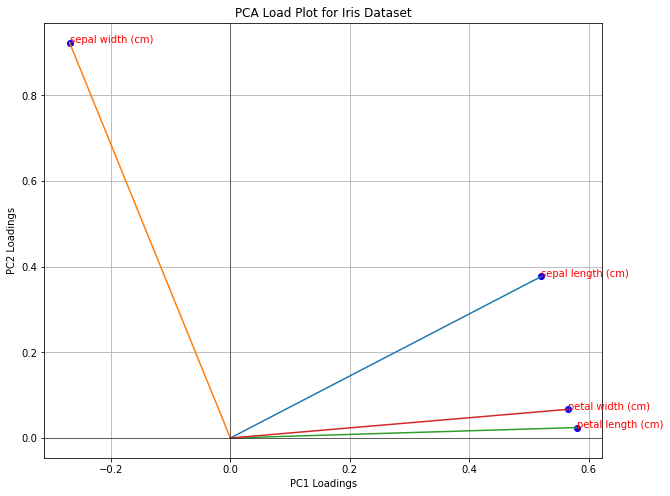

In [503]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Standardize the features (important for PCA)
scaler = StandardScaler()
iris_std = scaler.fit_transform(iris_df)

# Perform PCA
pca = PCA()
pca.fit(iris_std)

# Access the loadings (coefficients)
loadings = pca.components_

# Create a load plot
plt.figure(figsize=(10, 8))

# Plot loadings for the first two principal components
plt.scatter(loadings[0, :], loadings[1, :], marker='o', color='blue')

# Annotate each point with the variable names
for i, var_name in enumerate(iris_df.columns):
    plt.annotate(var_name, (loadings[0, i], loadings[1, i]), color='red')
    plt.plot([0,loadings[0,i]], [0, loadings[1,i]])

# Add labels and title
plt.xlabel('PC1 Loadings')
plt.ylabel('PC2 Loadings')
plt.title('PCA Load Plot for Iris Dataset')

# Add grid lines for reference
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid()

# Show the plot
plt.show()


In a load plot: 
* variables that cluster together are positively correlated, while variables on opposite sides may be negatively correlated;
* variables which are further from the origin have higher loadings, so they are more influential in the computation of the PCA.

A loading plot can also be useful to perform feature selection. For instance, from the plot above all variables seem to be influential, but `petal width` and `petal length` are correlated. We could think of using as a subset of variables `sepal width`, `sepal length` and one of the other two (e.g., `petal length`).

## Applications of PCA
PCA has several applications in data analysis. We will summarize the main ones in the following.

### Dimensionality Reduction and Visualization

We have seen that data can be interpreted as a set of D-dimensional points. When $D=2$, it is often useful to visualize the data through a scatterplot. This allows us to see how the data distributes in the space. When $D>2$, we can show a series a scatterplot (a pairplot or scattermatrix). However, when $D$ is very large, it is usually unfeasible to visualize data with all possible scatterplots.

In these cases, it can be useful to transform the data with PCA and then visualize the data points as 2D points in the space identified by the first two principal components. 

We will show an example on the multidimensional dataset **DIGITS**. The dataset contains small images of resolution $8 \times 8 pixels$ representing handwritten digits from $0$ to $9$. We can see the dataset as containing $64$ variables. Each variable indicates the pixel value at a specific location.


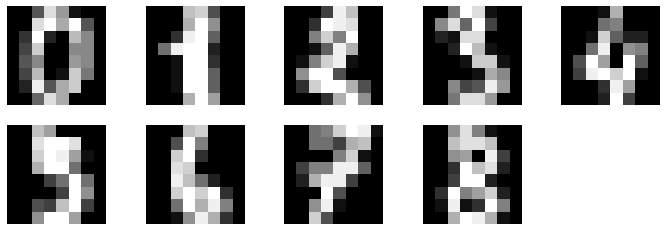

In [514]:
from sklearn.datasets import load_digits
digits=load_digits()

plt.figure(figsize=(12,4))
for i in range(9):
    plt.subplot(2,5,i+1)
    plt.imshow(digits.data[i].reshape((8,8)),cmap='gray')
    plt.axis('off')
plt.show()

We can visualize the data with PCA by first projecting the data to $M=2$ principal components, then plotting the transformed data as 2D points.

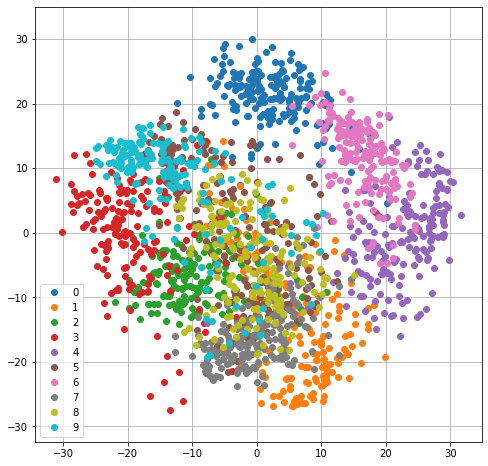

In [517]:
pca=PCA(n_components=2)
pca.fit(digits.data)
Y=pca.transform(digits.data)

plt.figure(figsize=(8,8))
legend = []
for c in np.unique(digits.target):
    plt.plot(Y[digits.target==c,0],Y[digits.target==c,1],'o')
    legend.append(c)

plt.legend(legend)
plt.grid()
plt.axis('equal')
plt.show()

### Data Decorrelation - Principal Component Regression
PCA is also useful when we need to fit a linear regressor and we are in the presence of a dataset with multi-collinearity.

Let us consider the `auto_mpg` dataset:

In [533]:
from scipy.stats import zscore
from ucimlrepo import fetch_ucirepo 
from statsmodels.formula.api import ols
import pandas as pd
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9)
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
data = X.join(y)
data

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,307.0,8,130.0,3504,12.0,70,1,18.0
1,350.0,8,165.0,3693,11.5,70,1,15.0
2,318.0,8,150.0,3436,11.0,70,1,18.0
3,304.0,8,150.0,3433,12.0,70,1,16.0
4,302.0,8,140.0,3449,10.5,70,1,17.0
...,...,...,...,...,...,...,...,...
393,140.0,4,86.0,2790,15.6,82,1,27.0
394,97.0,4,52.0,2130,24.6,82,2,44.0
395,135.0,4,84.0,2295,11.6,82,1,32.0
396,120.0,4,79.0,2625,18.6,82,1,28.0


If we try to fit a linear regressor with all variables, we will find multicollinearity:

In [535]:
from statsmodels.formula.api import ols
ols("mpg ~ displacement + cylinders + horsepower + weight + acceleration + model_year + origin", data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-17.2184,4.644,-3.707,0.000,-26.350,-8.087
displacement,0.0199,0.008,2.647,0.008,0.005,0.035
cylinders,-0.4934,0.323,-1.526,0.128,-1.129,0.142
horsepower,-0.0170,0.014,-1.230,0.220,-0.044,0.010
weight,-0.0065,0.001,-9.929,0.000,-0.008,-0.005
acceleration,0.0806,0.099,0.815,0.415,-0.114,0.275
model_year,0.7508,0.051,14.729,0.000,0.651,0.851
origin,1.4261,0.278,5.127,0.000,0.879,1.973


Indeed, some variables have a large p-value, probably because they are correlated with the others.

To perform Principal Component Regression, we can first compute PCA **on the independent variables**, then fit a linear regressor. We will choose $M=4$ principal components:

In [553]:
pca = PCA(n_components=4)
dd = data.dropna()
pca.fit(dd.drop('mpg', axis=1))
zz = pca.transform(dd.drop('mpg', axis=1))

data2 = pd.DataFrame({
    f"z{i+1}": zz[:,i]
    for i in range(zz.shape[1])
})

data2=data2.join(dd['mpg'])

print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())

ols("mpg ~ z1 + z2 + z3 + z4", data2).fit().summary()


Cumulative explained variance: [0.99756151 0.9996243  0.99998025 0.9999952 ]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     92.20
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           9.24e-55
Time:                        12:53:09   Log-Likelihood:                -1207.7
No. Observations:                 386   AIC:                             2425.
Df Residuals:                     381   BIC:                             2445.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.3607      0.283     82.480      0.000      22.804      23.918
z1            -0.0051      0.000    -15.346      0.000      -0.006      -0.004
z2            -0.0320      0.007     -4.373      0.000      -0.046      -0.018
z3            -0.0552      0.018     -3.138      0.002      -0.090      -0.021
z4            -0.8815      0.086    -10.234      0.000      -1.051      -0.712
==============================================================================
Omnibus:                        3.702   Durbin-Watson:                   1.125
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.435
Skew:                           0.214   Prob(JB):                        0.179
Kurtosis:                       3.174   Cond. No.                         860.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

While the result is not as interpretable as it was before, this technique may be useful in the case of predictive analysis.

### Data Compression

Now let's see a simple example of data compression using PCA. In particular, we will consider the case of compressing images. An image can be seen as high-dimensional data, where the number of dimensions is equal to the number of pixels. For example, an RGB image of size $640 \times 480$ pixels has $3 \cdot 640 \cdot 480=921600$ dimensions. 

We expect that there will be redundant information in all these dimensions. One method to compress images is to divide them into fixed-size blocks (e.g., $8 \times 8$). Each of these blocks will be an element belonging to a population (the population of $8 \times 8$ blocks of the image). 

Assuming that the information in the blocks is highly correlated, we can try to compress it by applying PCA to the sample of blocks extracted from our image and choosing only a few principal components to represent the content of the blocks.

We will consider the following example image:

Image Size: (427, 640, 3)
Number of dimensions: 819840


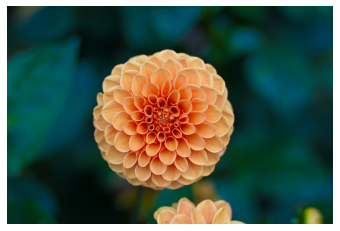

In [559]:
from sklearn.datasets import load_sample_image
flower = load_sample_image('flower.jpg')
print("Image Size:",flower.shape)
print("Number of dimensions:",np.prod(flower.shape))
plt.imshow(flower)
plt.axis('off')
plt.show()


We will divide the image into RGB blocks of size $8 \times 8 \times 3$ (these are $8 \times 8$ RGB images). These will look as follows:

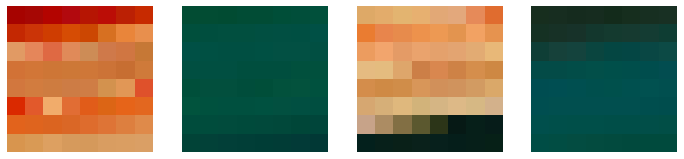

In [561]:
tiles = np.split(flower.ravel(),4270)
tiles=np.stack(tiles)
tiles.shape

plt.figure(figsize=(12,8))
plt.subplot(141)
plt.imshow(tiles[1855].reshape(8,8,3))
plt.axis('off')
plt.subplot(142)
plt.imshow(tiles[2900].reshape(8,8,3))
plt.axis('off')
plt.subplot(143)
plt.imshow(tiles[1856].reshape(8,8,3))
plt.axis('off')
plt.subplot(144)
plt.imshow(tiles[960].reshape(8,8,3))
plt.axis('off')
plt.show()

If we compute the PCA of all blocks, we will obtain the following cumulative variance ratio vector:

In [ ]:
pca=PCA()
pca.fit(tiles)
np.cumsum(pca.explained_variance_ratio_)[:32]

array([0.72033322, 0.8054948 , 0.88473857, 0.91106289, 0.92773705,
       0.94002709, 0.94742984, 0.95262262, 0.95724086, 0.96138203,
       0.96493482, 0.96813026, 0.97074765, 0.97304417, 0.97502487,
       0.97676849, 0.97827393, 0.97961611, 0.98080084, 0.98195037,
       0.98298693, 0.98399279, 0.98491245, 0.98570784, 0.98649079,
       0.98719466, 0.98779928, 0.98835152, 0.98888528, 0.98937606,
       0.98983658, 0.99027875])

As we can see, truncating at the first component allows us to retain about $72%$ of the information, truncating at the second allows us to retain about $80%$, and so on, up to $32$ components, which allow us to retain about $99%$ of the information. Now let's see how to compress and reconstruct the image. We will choose the first $32$ components, preserving $99%$ of the information. 

If we do so, and then project the tiles to the compressed space each tile will be represented by only $32$ numbers. This will lead to the following savings in space:

In [562]:
pca = PCA(n_components=32)
pca.fit(tiles)
compressed_tiles = pca.transform(tiles)
compressed_tiles.shape

print("Space saved in the compression: {:0.2f}%".format(100-100*compressed_tiles.size/tiles.size))

Space saved in the compression: 83.33%


We can reconstruct the original image by applying the inverse PCA transformation to the compressed patches. The result will be as follows:

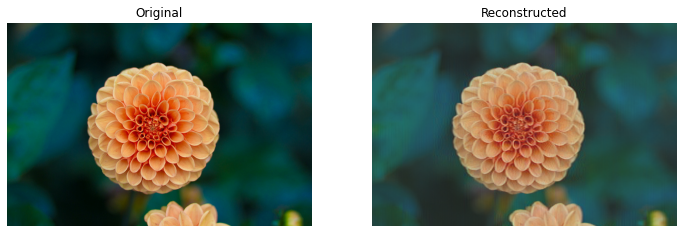

In [565]:
reconstructed_tiles = pca.inverse_transform(compressed_tiles)
reconstructed_tiles.shape

reconstructed_tiles = (reconstructed_tiles-reconstructed_tiles.min())\
            /(reconstructed_tiles.max()-reconstructed_tiles.min())*255
reconstructed_tiles=reconstructed_tiles.astype('uint8')

reconstructed_flower=reconstructed_tiles.ravel().reshape(flower.shape)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(flower)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Reconstructed')
plt.imshow(reconstructed_flower)
plt.axis('off')
plt.show()

The plot below shows how the reconstruction quality increases when more components are used:

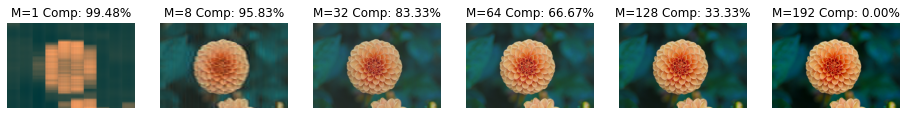

In [578]:
def compress(n_components):
    pca = PCA(n_components=n_components)
    pca.fit(tiles)
    compressed_tiles = pca.transform(tiles)
    compressed_tiles.shape

    saved_sapce = 100-100*compressed_tiles.size/tiles.size

    reconstructed_tiles = pca.inverse_transform(compressed_tiles)
    reconstructed_tiles.shape

    reconstructed_tiles = (reconstructed_tiles-reconstructed_tiles.min())\
                /(reconstructed_tiles.max()-reconstructed_tiles.min())*255
    reconstructed_tiles=reconstructed_tiles.astype('uint8')

    reconstructed_flower=reconstructed_tiles.ravel().reshape(flower.shape)

    return reconstructed_flower, saved_sapce

plt.figure(figsize=(16,4))
for i,c in enumerate([1,8,32,64,128,192]):
    plt.subplot(1,6,i+1)
    reconstructed, saved_space = compress(c)
    plt.imshow(reconstructed)
    plt.axis('off')
    plt.title(f"M={c} Comp: {saved_space:0.2f}%")

## References

\[1\] Parts of Chapter 12 of Bishop, Christopher M., and Nasser M. Nasrabadi. Pattern recognition and machine learning. Vol. 4. No. 4. New York: springer, 2006.